# Modular TRM Training for Graph Coloring

This notebook demonstrates a modular approach to training and evaluating a TRM neural network on synthetic graph coloring puzzles using PyTorch. The code is organized for easy adaptation to other graph-based problems.

## 1. Import Libraries and Set Up Environment
Import all required libraries, set random seeds, and configure device (CPU/GPU).

In [29]:
import os, math, random
from dataclasses import dataclass
from typing import Tuple, Any, List
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
import sys
sys.path.append(os.path.join("..", "src"))
from exploretinyrm.trm import TRM, TRMConfig
def set_seed(seed: int = 123):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## 2. AMP and EMA Utilities
Define automatic mixed precision (AMP) and exponential moving average (EMA) utility functions and classes.

In [30]:
try:
    from torch.amp import autocast as _autocast, GradScaler as _GradScaler
    _USE_TORCH_AMP = True
except ImportError:
    from torch.cuda.amp import autocast as _autocast, GradScaler as _GradScaler
    _USE_TORCH_AMP = False

def make_grad_scaler(is_cuda: bool):
    if _USE_TORCH_AMP:
        try:
            return _GradScaler("cuda", enabled=is_cuda)
        except TypeError:
            return _GradScaler(enabled=is_cuda)
    else:
        return _GradScaler(enabled=is_cuda)

def amp_autocast(is_cuda: bool, use_amp: bool):
    if _USE_TORCH_AMP:
        try:
            return _autocast(device_type="cuda", enabled=(is_cuda and use_amp))
        except TypeError:
            return _autocast(enabled=(is_cuda and use_amp))
    else:
        return _autocast(enabled=(is_cuda and use_amp))

class EMA:
    def __init__(self, model: torch.nn.Module, decay: float = 0.999):
        self.decay = decay
        self.shadow = {
            name: param.detach().clone()
            for name, param in model.named_parameters()
            if param.requires_grad
        }

    def update(self, model: torch.nn.Module) -> None:
        d = self.decay
        with torch.no_grad():
            for name, param in model.named_parameters():
                if not param.requires_grad:
                    continue
                self.shadow[name].mul_(d).add_(param.detach(), alpha=1.0 - d)

    def copy_to(self, model: torch.nn.Module) -> None:
        with torch.no_grad():
            for name, param in model.named_parameters():
                if name in self.shadow:
                    param.copy_(self.shadow[name])

from contextlib import contextmanager

@contextmanager
def use_ema_weights(model: torch.nn.Module, ema: EMA):
    backup = {
        name: param.detach().clone()
        for name, param in model.named_parameters()
        if param.requires_grad
    }
    ema.copy_to(model)
    try:
        yield
    finally:
        with torch.no_grad():
            for name, param in model.named_parameters():
                if name in backup:
                    param.copy_(backup[name])

## 3. Graph Coloring Dataset Preparation
Implement dataset generation for synthetic undirected graph coloring puzzles.

In [31]:
class GameDataset(Dataset):
    """Base class for game datasets. Subclass and implement _generate_sample."""
    def __init__(self, n_samples: int, seed: int = 0):
        self.rng = np.random.default_rng(seed)
        self.samples = [self._generate_sample() for _ in range(n_samples)]
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]
    def _generate_sample(self): raise NotImplementedError()

class GraphColoringDataset(GameDataset):
    """Synthetic undirected graph coloring puzzles."""
    def __init__(self, n_samples: int, n_nodes: int = 6, n_colors: int = 3, edge_prob: float = 0.4, seed: int = 0):
        self.n_nodes = n_nodes
        self.n_colors = n_colors
        self.edge_prob = edge_prob
        super().__init__(n_samples, seed)
    def _generate_sample(self):
        # Regenerate until a valid coloring is found (no -1 values)
        while True:
            adj = np.triu((self.rng.random((self.n_nodes, self.n_nodes)) < self.edge_prob).astype(np.int64), 1)
            adj = adj + adj.T
            colors = np.full(self.n_nodes, -1, dtype=np.int64)
            for node in range(self.n_nodes):
                forbidden = set(colors[adj[node] == 1])
                for c in range(self.n_colors):
                    if c not in forbidden:
                        colors[node] = c
                        break
            if np.all((colors >= 0) & (colors < self.n_colors)):
                x_tokens = adj.flatten()
                y_tokens = colors
                return torch.from_numpy(x_tokens), torch.from_numpy(y_tokens)

def get_gc_loaders(n_train=512, n_val=128, batch_size=16, n_nodes=6, n_colors=3, edge_prob=0.4, seed=123):
    ds_tr = GraphColoringDataset(n_train, n_nodes=n_nodes, n_colors=n_colors, edge_prob=edge_prob, seed=seed)
    ds_va = GraphColoringDataset(n_val, n_nodes=n_nodes, n_colors=n_colors, edge_prob=edge_prob, seed=seed+1)
    return (
        DataLoader(ds_tr, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True),
        DataLoader(ds_va, batch_size=batch_size, shuffle=False, pin_memory=True)
    )
 
train_loader, val_loader = get_gc_loaders(
    n_train=2048,
    n_val=512,
    batch_size=16,
    n_nodes=4, #N_NODES
    n_colors=3,
    edge_prob=0.2,
    seed=123
)

In [32]:
N_NODES = 4
N_COLORS = 3
INPUT_TOKENS = 2  # adjacency matrix entries: 0 or 1
OUTPUT_TOKENS = N_COLORS  # color labels: 0..N_COLORS-1
SEQ_LEN = N_NODES * N_NODES

D_MODEL = 128
N_SUP   = 16
N       = 6
T       = 3
USE_ATT = False

In [33]:
# show some examples of the dataset
for i in range(2):
    x, y = train_loader.dataset[i]
    print(f"Example {i}:")
    print("Input Adjacency Matrix:")
    adj_matrix = x.numpy().reshape(N_NODES, N_NODES)
    print(adj_matrix)
    print("Node Colors:")
    print(y.numpy())
    print()

Example 0:
Input Adjacency Matrix:
[[0 1 0 1]
 [1 0 0 0]
 [0 0 0 0]
 [1 0 0 0]]
Node Colors:
[0 1 0 1]

Example 1:
Input Adjacency Matrix:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
Node Colors:
[0 0 0 0]



## 4. Model Configuration and Initialization
Configure TRM model parameters, instantiate the model, optimizer, scaler, and EMA for graph coloring.

In [34]:
cfg = TRMConfig(
    input_vocab_size=INPUT_TOKENS,
    output_vocab_size=OUTPUT_TOKENS,
    seq_len=SEQ_LEN,
    d_model=D_MODEL,
    n_layers=2, #8
    use_attention=USE_ATT,
    n_heads=8,
    dropout=0.0,
    mlp_ratio=4.0,
    token_mlp_ratio=2.0,
    n=N,
    T=T,
    k_last_ops=None,
    stabilize_input_sums=True
)

model = TRM(cfg).to(device)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)

optimizer = torch.optim.AdamW(
    model.parameters(), lr=3e-4, weight_decay=0.0, betas=(0.9, 0.95)
)

scaler = make_grad_scaler(device.type == "cuda")
ema = EMA(model, decay=0.999)

Params (M): 0.3968


## 5. Sanity Checks on Data
Run assertions to verify input and label ranges for the graph coloring dataset.

In [35]:
# Sanity checks for graph coloring data
# Check adjacency matrix shape and values, and color labels
for i in range(len(train_loader.dataset)):
    x, y = train_loader.dataset[i]
    adj = x.numpy().reshape(N_NODES, N_NODES)
    assert adj.shape == (N_NODES, N_NODES)
    assert np.all((adj == 0) | (adj == 1))
    assert y.shape[0] == N_NODES
    #assert np.all((y >= 0) & (y < N_COLORS))
    assert np.all((y.numpy() >= 0) & (y.numpy() < N_COLORS))
    # Check coloring validity: no adjacent nodes have same color
    for u in range(N_NODES):
        for v in range(u+1, N_NODES):
            if adj[u, v] == 1:
                assert y[u] != y[v], f"Nodes {u} and {v} have same color {y[u]}!"
print("Sanity OK: adjacency in {0,1}, colors in [0,N_COLORS-1], valid coloring.")

Sanity OK: adjacency in {0,1}, colors in [0,N_COLORS-1], valid coloring.


In [36]:
# check training data size
len(train_loader.dataset)

2048

c:\Users\mhopw\miniconda3\envs\torch121\Lib\site-packages\networkx\drawing\nx_pylab.py:1438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


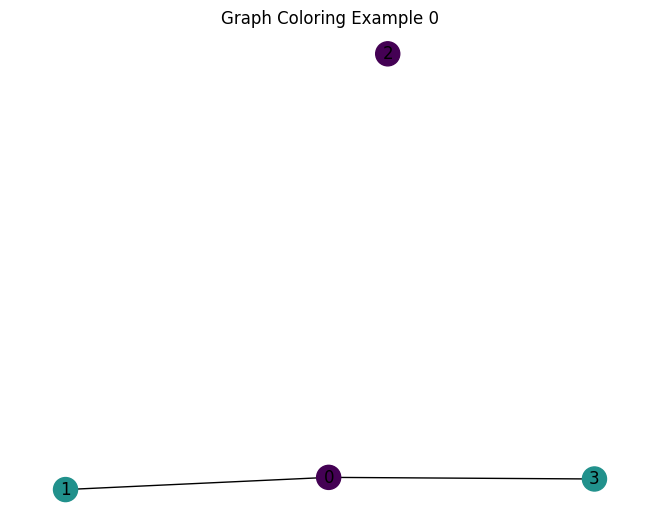

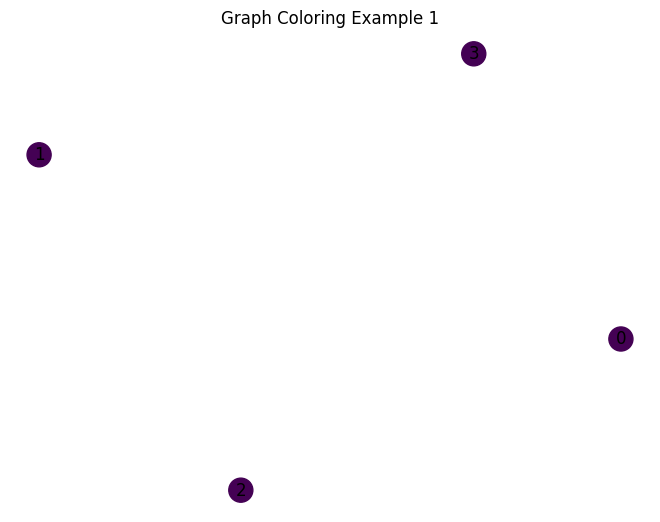

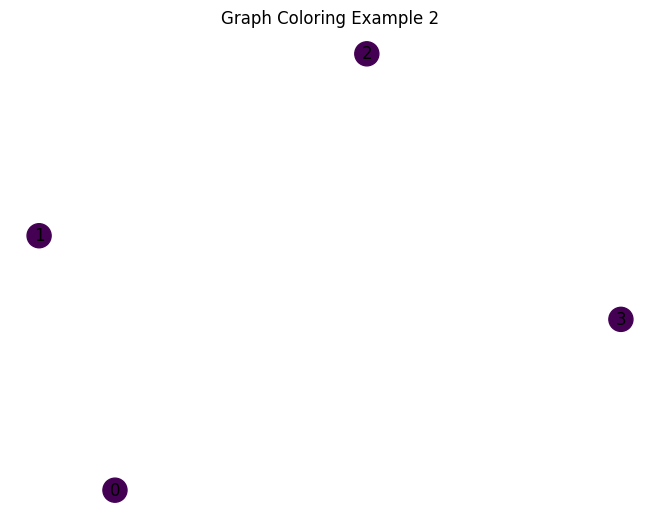

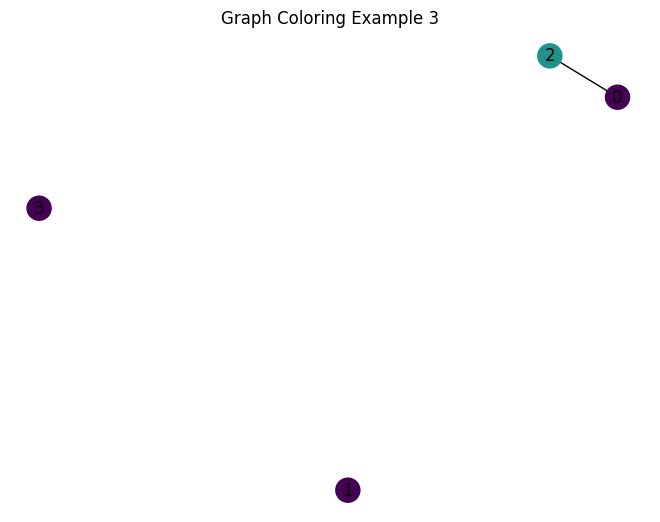

In [37]:
import networkx as nx
import matplotlib.pyplot as plt
for i in range(4):
    x, y = train_loader.dataset[i]
    adj = x.numpy().reshape(N_NODES, N_NODES)
    colors = y.numpy()
    G = nx.from_numpy_array(adj)
    color_map = plt.get_cmap('viridis', N_COLORS)
    node_colors = [color_map(c) for c in colors]
    plt.figure()
    nx.draw(G, with_labels=True, node_color=node_colors, cmap=color_map)
    plt.title(f"Graph Coloring Example {i}")
    plt.show()

In [38]:
bx, by = next(iter(train_loader))
assert bx.min().item() >= 0 and bx.max().item() <= 1
assert by.min().item() >= 0 and by.max().item() < N_COLORS
print("Sanity OK: adjacency in {0,1}, colors in [0,N_COLORS-1]")

Sanity OK: adjacency in {0,1}, colors in [0,N_COLORS-1]


## 6. Training and Evaluation Functions
Define training and evaluation functions, including loss calculation, metric reporting, and EMA evaluation for graph coloring.

In [39]:
def compute_class_weights(loader, n_classes):
    # Count occurrences of each class in the dataset
    counts = torch.zeros(n_classes)
    for _, y_true in loader:
        for c in range(n_classes):
            counts[c] += (y_true == c).sum().item()
    weights = 1.0 / (counts + 1e-6)
    weights = weights / weights.sum() * n_classes
    return weights

class_weights = compute_class_weights(train_loader, N_COLORS).to(device)

def node_ce_loss(logits: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    # logits: [B, N, C], y_true: [B, N]
    B, N, C = logits.shape
    return F.cross_entropy(logits.reshape(B*N, C), y_true.reshape(B*N), weight=class_weights)

import itertools

def coloring_max_match(preds, y_true, n_colors):
    """Return the max number of matches over all color permutations, normalized by number of nodes."""
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    y_true = y_true.cpu().numpy() if isinstance(y_true, torch.Tensor) else y_true
    max_match = 0
    for perm in itertools.permutations(range(n_colors)):
        mapping = {i: perm[i] for i in range(n_colors)}
        mapped_preds = [mapping[c] for c in preds]
        match = sum(mp == yt for mp, yt in zip(mapped_preds, y_true))
        if match > max_match:
            max_match = match
    return max_match / len(preds)

def node_exact_match_from_logits(logits: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    preds = logits.argmax(dim=-1)
    # For each sample in batch, get max match score
    batch_scores = []
    for i in range(preds.shape[0]):
        score = coloring_max_match(preds[i], y_true[i], N_COLORS)
        batch_scores.append(score)
    return torch.tensor(batch_scores, device=logits.device)

def train_one_epoch(
    model: TRM,
    loader: DataLoader,
    optimizer,
    scaler,
    epoch: int,
    use_amp: bool = True,
    ema: "EMA | None" = None
):
    model.train()
    total_ce, total_halt, total_em, total_steps = 0.0, 0.0, 0.0, 0
    for x_tokens, y_true in loader:
        x_tokens = x_tokens.to(device, non_blocking=True)
        y_true   = y_true.to(device,   non_blocking=True)
        y_state, z_state = model.init_state(batch_size=x_tokens.size(0), device=device)
        for _ in range(N_SUP):
            optimizer.zero_grad(set_to_none=True)
            y_state, z_state, logits, halt_logit = model.forward_step(
                x_tokens, y=y_state, z=z_state, n=N, T=T, k_last_ops=None
            )
            logits_nodes = logits.float().view(logits.size(0), N_NODES, N_NODES, logits.size(2)).mean(dim=2)
            loss_ce = F.cross_entropy(logits_nodes.reshape(-1, OUTPUT_TOKENS), y_true.reshape(-1),
                                      weight=class_weights)
            # loss_ce = node_ce_loss(logits_nodes.float(), y_true)
            with torch.no_grad():
                em = node_exact_match_from_logits(logits_nodes, y_true)

            # correct_indices = (em == 1.0).nonzero(as_tuple=True)[0]
            # for idx in correct_indices:
            #     print(f"Example {idx.item()}:")
            #     print("Logits:")
            #     print(logits_nodes[idx])
            #     print("Predicted colors:", logits_nodes[idx].argmax(dim=-1))
            #     print("True colors:", y_true[idx])

            loss_halt = F.binary_cross_entropy_with_logits(halt_logit.float(), em)
            loss = loss_ce + loss_halt
            if use_amp:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                if ema is not None:
                    ema.update(model)
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                if ema is not None:
                    ema.update(model)
            total_ce   += loss_ce.detach().item()
            total_halt += loss_halt.detach().item()
            total_em   += em.mean().item()
            total_steps += 1
    print(f"Epoch {epoch:02d} | CE {total_ce/max(1,total_steps):.4f} | HaltBCE {total_halt/max(1,total_steps):.4f} | Perm-inv match {total_em/max(1,total_steps):.3f}")

@torch.no_grad()
def evaluate(model: TRM, loader: DataLoader, n_sup_eval: int = N_SUP, show_examples: int = 3):
    model.eval()
    acc_list = []
    example_count = 0
    for x_tokens, y_true in loader:
        x_tokens = x_tokens.to(device)
        y_true   = y_true.to(device)
        y_state, z_state = model.init_state(batch_size=x_tokens.size(0), device=device)
        for _ in range(n_sup_eval):
            y_state, z_state, logits, halt_logit = model.forward_step(
                x_tokens, y=y_state, z=z_state, n=N, T=T, k_last_ops=None
            )
        logits_nodes = logits.float().view(logits.size(0), N_NODES, N_NODES, logits.size(2)).mean(dim=2)
        em = node_exact_match_from_logits(logits_nodes, y_true)
        acc = em.mean()
        acc_list.append(acc)
        # Print a few examples from the first batch
        if example_count < show_examples:
            preds = logits_nodes.argmax(dim=-1)
            xs = x_tokens.cpu().numpy()
            ys = y_true.cpu().numpy()
            preds_np = preds.cpu().numpy()
            logits_np = logits_nodes.cpu().numpy()
            for i in range(min(show_examples - example_count, xs.shape[0])):
                print(f"\nExample {example_count + 1}:")
                print("Adjacency matrix:")
                print(xs[i].reshape(N_NODES, N_NODES))
                print("Logits:")
                print(logits_np[i])
                print("Predicted colors:", preds_np[i])
                print("True colors:", ys[i])
                print("Perm-inv match score:", coloring_max_match(preds_np[i], ys[i], N_COLORS))
                example_count += 1
    acc = torch.stack(acc_list).mean().item()
    print(f"Validation | Perm-inv node match {acc:.3f}")
    return acc

@torch.no_grad()
def evaluate_with_ema(model: TRM, ema: EMA, loader: DataLoader, n_sup_eval: int = N_SUP):
    with use_ema_weights(model, ema):
        return evaluate(model, loader, n_sup_eval=n_sup_eval)

## 7. Training Loop
Run the main training loop for several epochs, reporting metrics for both raw and EMA weights.

In [40]:
EPOCHS = 5
for epoch in range(1, EPOCHS+1):
    train_one_epoch(model, train_loader, optimizer, scaler, epoch, use_amp=False, ema=ema)
    acc_raw = evaluate(model, val_loader)
    acc_ema = evaluate_with_ema(model, ema, val_loader)
    print(f"Validation (raw) | Node accuracy {acc_raw:.3f}")
    print(f"Validation (EMA) | Node accuracy {acc_ema:.3f}")

Epoch 01 | CE 0.2521 | HaltBCE 0.1550 | Perm-inv match 0.954

Example 1:
Adjacency matrix:
[[0 0 0 0]
 [0 0 1 0]
 [0 1 0 1]
 [0 0 1 0]]
Logits:
[[18.929314  -6.7435927 -1.6925788]
 [ 9.876171  -1.3105397 -5.4400177]
 [-3.1799524  3.0752478 -3.5740712]
 [-1.2211696  2.9040194 -4.900383 ]]
Predicted colors: [0 0 1 1]
True colors: [0 0 1 0]
Perm-inv match score: 0.75

Example 2:
Adjacency matrix:
[[0 0 1 1]
 [0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]
Logits:
[[12.898422  -1.5574739 -5.807005 ]
 [11.57817   -3.708339  -4.8628845]
 [-1.9593548  2.5366566 -3.3135312]
 [-5.9015265  2.7013264 -1.9022833]]
Predicted colors: [0 0 1 1]
True colors: [0 0 1 1]
Perm-inv match score: 1.0

Example 3:
Adjacency matrix:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 1 0]]
Logits:
[[18.061764  -5.3798723 -2.8087535]
 [10.276308  -2.746515  -4.908749 ]
 [10.073114  -2.1106706 -5.994753 ]
 [-3.5687213  4.510947  -5.626829 ]]
Predicted colors: [0 0 0 1]
True colors: [0 0 0 1]
Perm-inv match score: 1.0

Example 1:
Adjacency m

## 8. Model Inference and Visualization
Show predictions for a batch of graphs and compare to true colorings.

In [42]:
@torch.no_grad()
def show_predictions(model: TRM, loader: DataLoader, n_batches: int = 1):
    model.eval()
    shown = 0
    for x_tokens, y_true in loader:
        x_tokens = x_tokens.to(device)
        y_true   = y_true.to(device)
        y_state, z_state = model.init_state(batch_size=x_tokens.size(0), device=device)
        for _ in range(N_SUP):
            y_state, z_state, logits, halt_logit = model.forward_step(
                x_tokens, y=y_state, z=z_state, n=N, T=T, k_last_ops=None
            )
        # logits = logits.view(x_tokens.size(0), N_NODES, N_COLORS)
        logits_nodes = logits.view(logits.size(0), N_NODES, N_NODES, logits.size(2)).mean(dim=2)
        preds = logits_nodes.argmax(dim=-1).cpu().numpy()
        xs = x_tokens.cpu().numpy()
        ys = y_true.cpu().numpy()
        for i in range(min(4, xs.shape[0])):
            print(f"\nGraph {shown+i}:")
            print("Adjacency matrix:")
            print(xs[i].reshape(N_NODES, N_NODES))
            print(logits_nodes[i])
            print("Predicted colors:", preds[i])
            print("True colors:", ys[i])
        shown += 1
        if shown >= n_batches:
            break

show_predictions(model, val_loader, n_batches=1)


Graph 0:
Adjacency matrix:
[[0 0 0 0]
 [0 0 1 0]
 [0 1 0 1]
 [0 0 1 0]]
tensor([[ 28.0305, -10.8967,   3.7622],
        [ 13.3339,  -0.7180,  -6.0634],
        [-15.2419,  13.9771, -20.3162],
        [  9.0574,  -6.6605,   4.1555]], device='cuda:0')
Predicted colors: [0 0 1 0]
True colors: [0 0 1 0]

Graph 1:
Adjacency matrix:
[[0 0 1 1]
 [0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]
tensor([[ 18.4609,  -1.3646,  -6.8100],
        [ 19.2939,  -5.2545,  -2.7636],
        [-17.0366,  10.5402, -11.2468],
        [ -8.1020,   1.7035,  -6.3288]], device='cuda:0')
Predicted colors: [0 0 1 1]
True colors: [0 0 1 1]

Graph 2:
Adjacency matrix:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 1 0]]
tensor([[ 23.2246,  -2.0597,  -6.1191],
        [ 20.2274,  -7.5212,  -0.6361],
        [ 15.8085,  -3.6406,  -5.4000],
        [-13.8869,   5.8077,  -7.6902]], device='cuda:0')
Predicted colors: [0 0 0 1]
True colors: [0 0 0 1]

Graph 3:
Adjacency matrix:
[[0 0 1 1]
 [0 0 1 0]
 [1 1 0 0]
 [1 0 0 0]]
tensor([[ 17.7843,  -